In [1]:
import scanpy as sc
import scrublet as scr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
%matplotlib inline

In [3]:
sc.settings.verbosity = 3
sc.settings._vector_friendly = False

plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.family"] = ["Arial"]
plt.rcParams["font.sans-serif"] = ["Arial"]

In [4]:
DATA_DIR = Path("/projects/robson-lab/research/brain-stem_rtn/data")
OUTPUT_DIR = Path("/projects/robson-lab/research/brain-stem_rtn/analysis/neurons")
AGG_NAME = "neuronal_agg"

In [5]:
from datetime import datetime

def timestamp():
    return datetime.now().strftime("%Y-%m-%dT%H-%M-%S")

def save_adata(adata, suffix="", subdir=""):
    filename = f"{adata.uns['library_id']}{'-' + suffix if suffix else ''}-{timestamp()}.h5ad"
    sc.write(Path(adata.uns["output_dir"]) / subdir / filename, adata)

In [480]:
from scipy.cluster.hierarchy import linkage, leaves_list
from scanpy.plotting._anndata import _prepare_dataframe
def reorder_clusters_hierarchical(adata, cluster_key, new_key="cluster", return_z=False):
    cats, tidy = _prepare_dataframe(
        adata,
        adata.var_names[adata.var.highly_variable],
        groupby=cluster_key,
        use_raw=False
    )
    mean_obs = tidy.groupby(level=0).mean()
    Z = linkage(mean_obs, method="ward", metric="euclidean", optimal_ordering=True)
    cluster_order = leaves_list(Z)

    new_clusters = (np.arange(len(cats)) + 1).astype(str)
    adata.obs[new_key] = adata.obs[cluster_key].map(
        dict(zip(cats[cluster_order], new_clusters))
    )
    adata.obs[new_key].cat.reorder_categories(new_clusters, inplace=True)

    if return_z:
        return adata, Z
    return adata

from scipy.spatial.distance import cdist
from scipy.stats import median_absolute_deviation
def detect_umap_doublets(adata, cluster_key, t=10):
    if "visible_doublet" in adata.obs_keys():
        adata.obs.drop("visible_doublet", inplace=True, axis=1)

    adata.obs["visible_doublet"] = False
    for cluster in adata.obs[cluster_key].cat.categories:
        inds = adata.obs_names[adata.obs[cluster_key] == cluster]
        coords = adata[inds].obsm["X_umap"]
        centroid = np.median(coords,axis=0)

        dists = cdist(coords, [centroid])
        thresh = t * median_absolute_deviation(dists)
        outliers = (dists > thresh).flatten()
        adata.obs.loc[inds[outliers], "visible_doublet"] = True

# Load in data

In [7]:
OUTPUT_DIR = Path("/projects/robson-lab/research/brain-stem_rtn/analysis/neurons")
FIGURE_DIR = Path("/projects/robson-lab/research/brain-stem_rtn/analysis/neurons/figures")

In [8]:
full = sc.read(OUTPUT_DIR / "h5ad" / "neuronal_agg-clustered-2020-05-31T11-00-35.h5ad")
slc17a6 = sc.read(OUTPUT_DIR / "h5ad" / "neuronal_agg-slc17a6-2020-05-31T14-27-13.h5ad")
slc32a1 = sc.read(OUTPUT_DIR / "h5ad" / "neuronal_agg-slc32a1-nodub-2020-05-31T16-45-53.h5ad")

## Load in Colin's clustering

In [9]:
def load_loupe_clusters(fname):
    # need to do this because the aggregation had an extra sample in it when we generated the loupe.
    df = pd.read_csv(OUTPUT_DIR / fname, index_col=0)
    df.index = df.index.str.replace("-", "-1-")
    bcs = df.reset_index()["Barcode"].str.split("-", expand=True)
    bcs.iloc[:, -1] = bcs.iloc[:, -1].map({"1":"0", "3":"1"})
    df.index = bcs.agg('-'.join, axis=1)
    return df

In [10]:
slc17a6_clusters = load_loupe_clusters("Excitatory Clustering.csv")
slc32a1_clusters = load_loupe_clusters("Inhibitory Clustering.csv")

In [11]:
slc17a6.obs["cluster_supervised"] = slc17a6_clusters.loc[slc17a6.obs_names, "Excitatory Cluster"]
slc32a1.obs["cluster_supervised"] = slc32a1_clusters.loc[slc32a1.obs_names, "Inhibitory Cluster"]

... storing 'cluster_supervised' as categorical


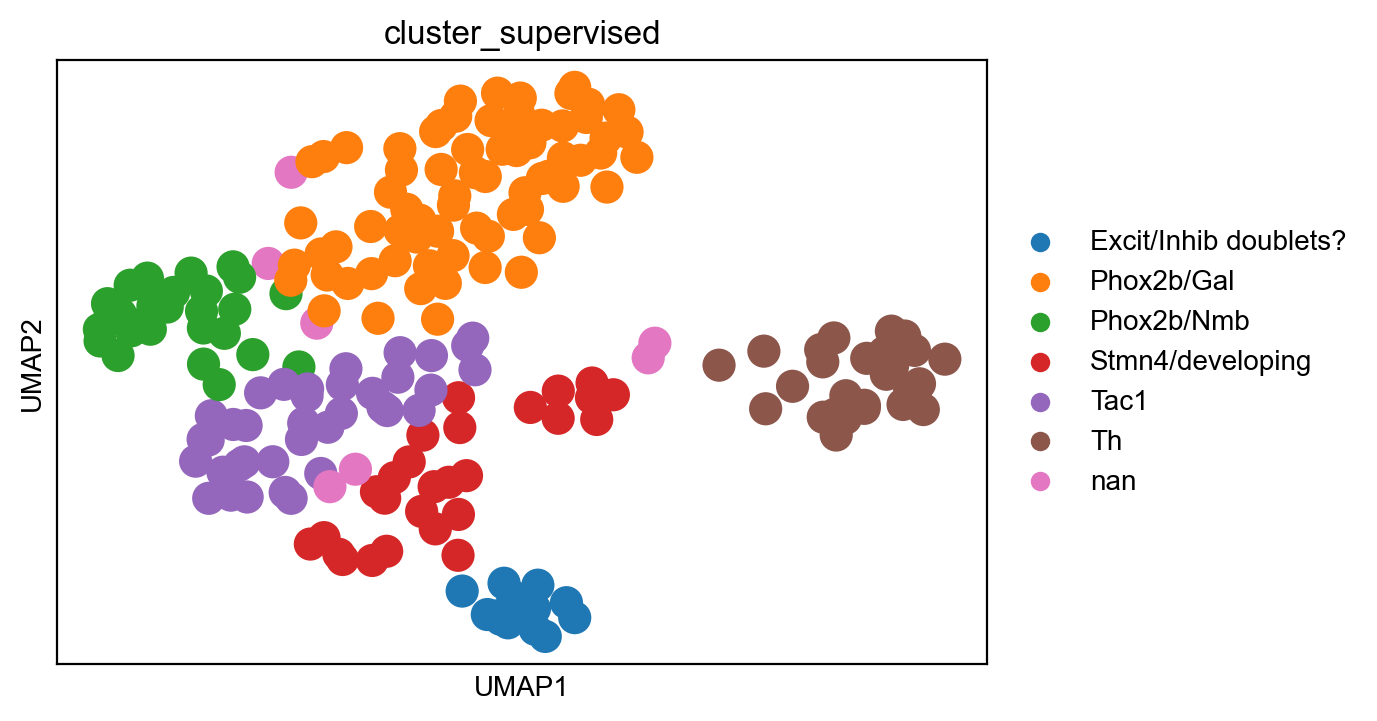

In [12]:
sc.pl.umap(slc17a6, color="cluster_supervised")

In [13]:
sc.tl.leiden(slc17a6, resolution=0.3)
sc.tl.leiden(slc17a6, restrict_to=("leiden", ["1",]), resolution=0.5, key_added="leiden_R0")
sc.tl.leiden(slc17a6, restrict_to=("leiden_R0", ["0",]), resolution=0.25, key_added="leiden_R1")

running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_R0', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_R1', the cluster labels (adata.obs, categorical) (0:00:00)


In [14]:
slc17a6_final = reorder_clusters_hierarchical(slc17a6, "leiden_R1")

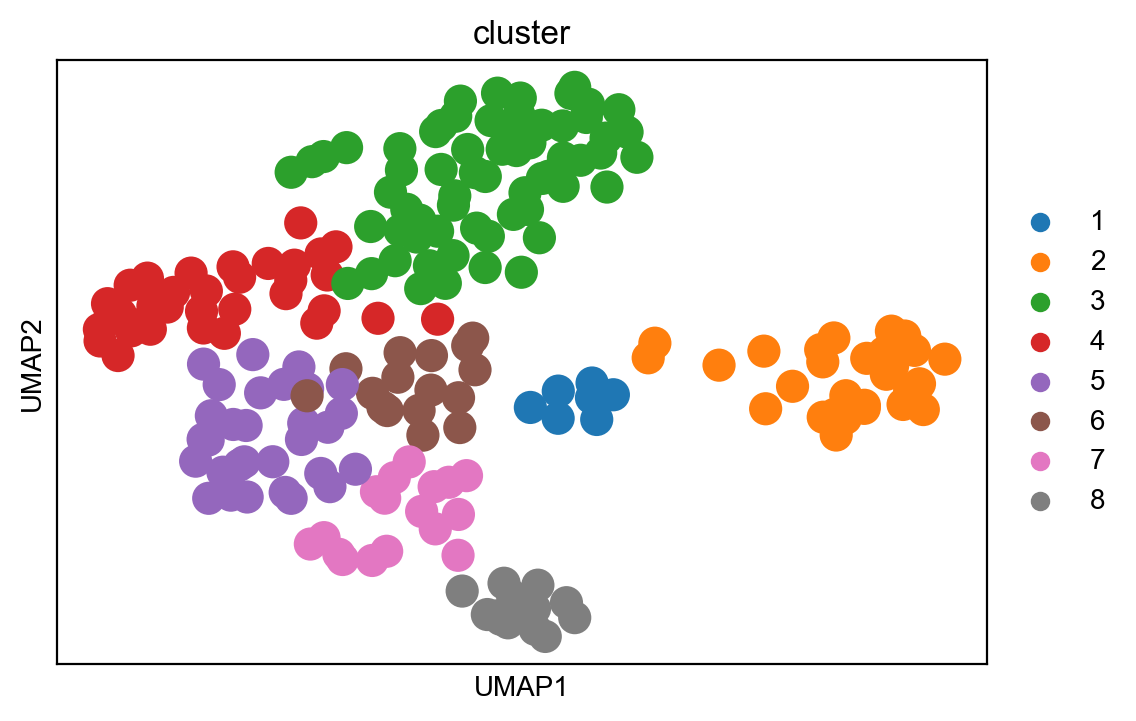

In [15]:
sc.pl.umap(slc17a6, color="cluster")

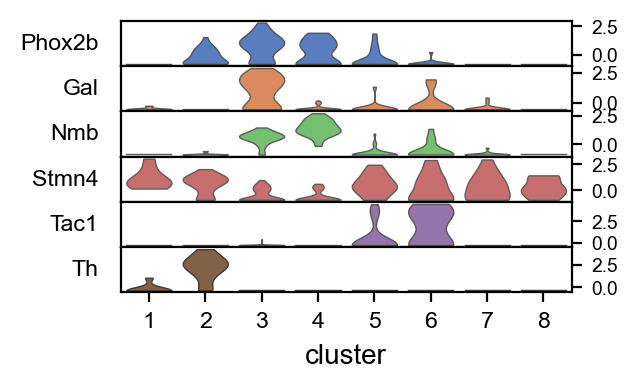

In [16]:
sc.pl.stacked_violin(slc17a6_final, ["Phox2b", "Gal", "Nmb", "Stmn4", "Tac1", "Th"], groupby="cluster", swap_axes=True)

... storing 'cluster_supervised' as categorical


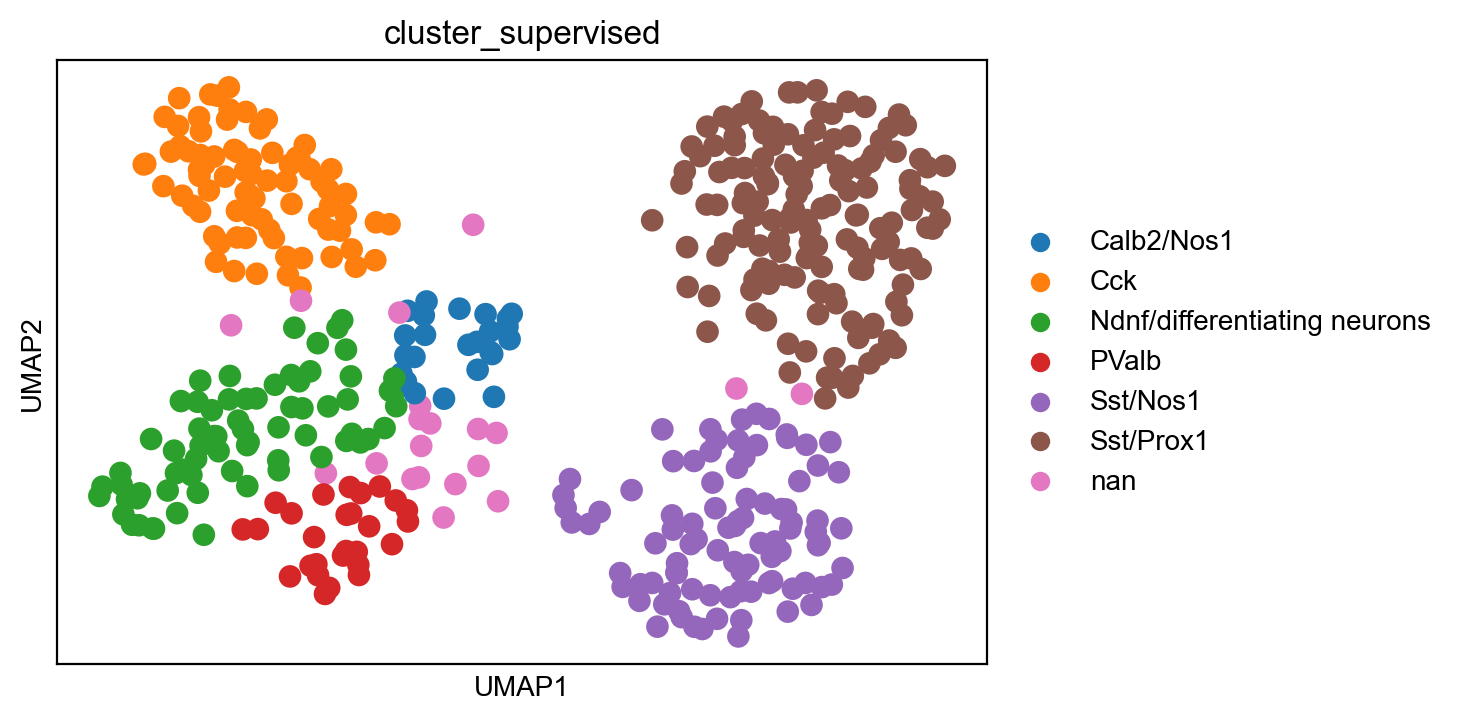

In [12]:
sc.pl.umap(slc32a1, color="cluster_supervised")

In [216]:
slc32a1.obs["Sst+Pvalb"] = (slc32a1[:, ["Sst", "Pvalb"]].X > 0).sum(axis=1) == 2

In [461]:
sc.tl.leiden(slc32a1, resolution=0.88, directed=True)
sc.tl.leiden(slc32a1, restrict_to=("leiden", ("4","5",)), resolution=0.5, directed=True)
sc.tl.leiden(slc32a1, restrict_to=("leiden_R", ("4-5,0",)), resolution=1.1, directed=True)
sc.tl.leiden(slc32a1, restrict_to=("leiden_R", ("4-5,1",)), resolution=1.1, directed=True)

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden_R', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden_R', the cluster labels (adata.obs, categorical) (0:00:00)


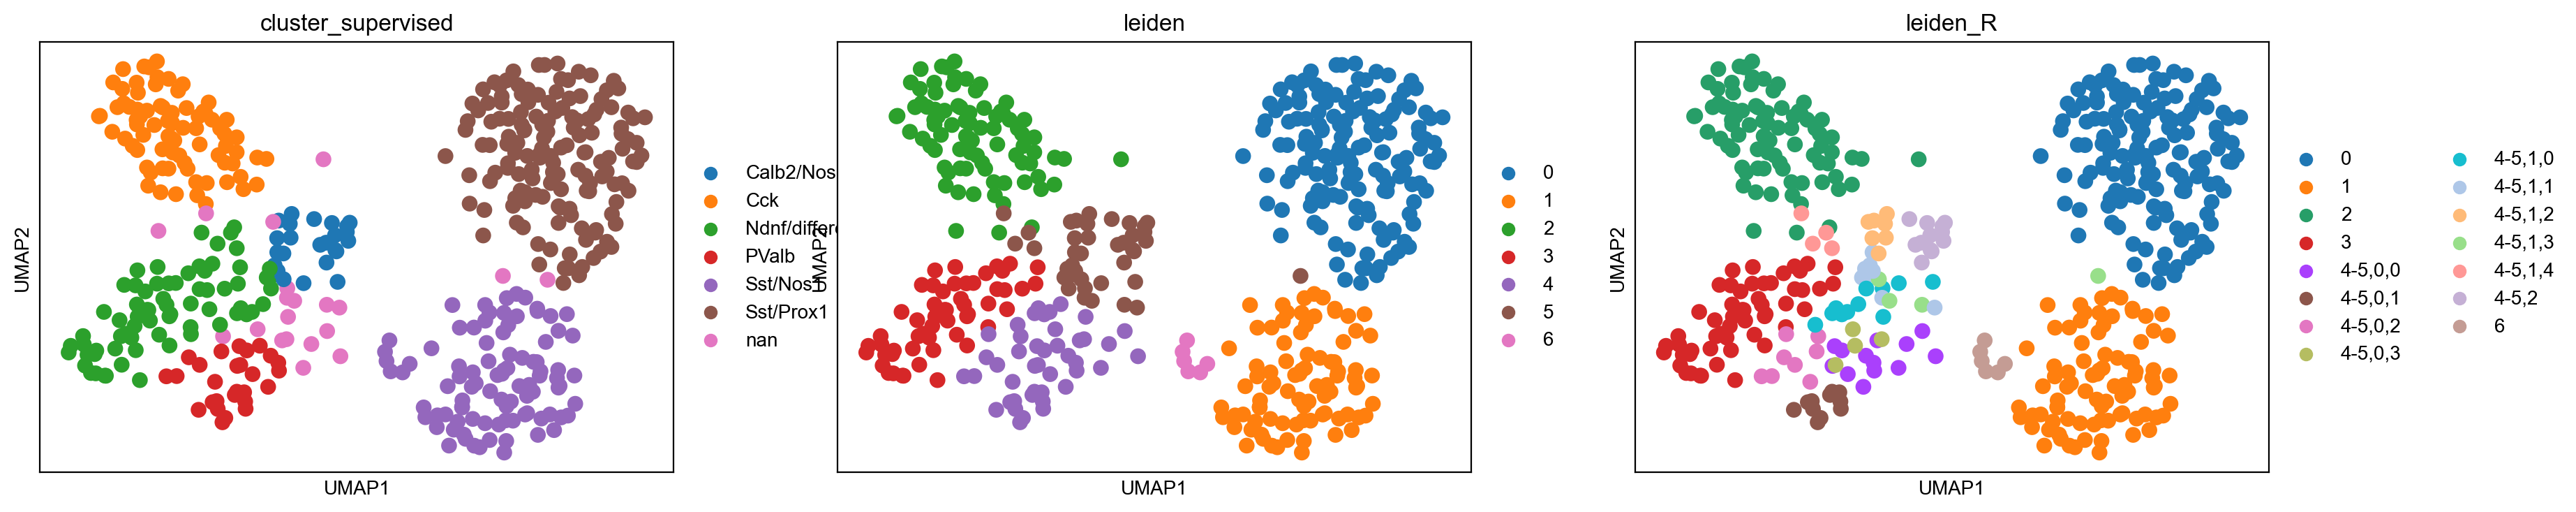

In [462]:
sc.pl.umap(slc32a1, color=["cluster_supervised", "leiden", "leiden_R"])

In [496]:
slc32a1.obs["leiden_final_1"] = slc32a1.obs.leiden_R.map({
    "0": "0", "1":"1", "2":"2", "3":"3", "6":"7",
    "4-5,0,0": "4", "4-5,0,1": "5", "4-5,0,2": "4",  "4-5,0,3": "4", 
    "4-5,1,0": "4", "4-5,1,1": "4", "4-5,1,2": "4", "4-5,1,3": "4", "4-5,1,4": "2", 
    "4-5,2": "6"
})
slc32a1.obs["leiden_final_2"] = slc32a1.obs.leiden_R.map({
    "0": "0", "1":"1", "2":"2", "3":"3", "6":"7",
    "4-5,0,0": "4", "4-5,0,1": "5", "4-5,0,2": "5",  "4-5,0,3": "4", 
    "4-5,1,0": "4", "4-5,1,1": "4", "4-5,1,2": "4", "4-5,1,3": "4", "4-5,1,4": "2", 
    "4-5,2": "6"
})

... storing 'leiden_final_1' as categorical
... storing 'leiden_final_2' as categorical


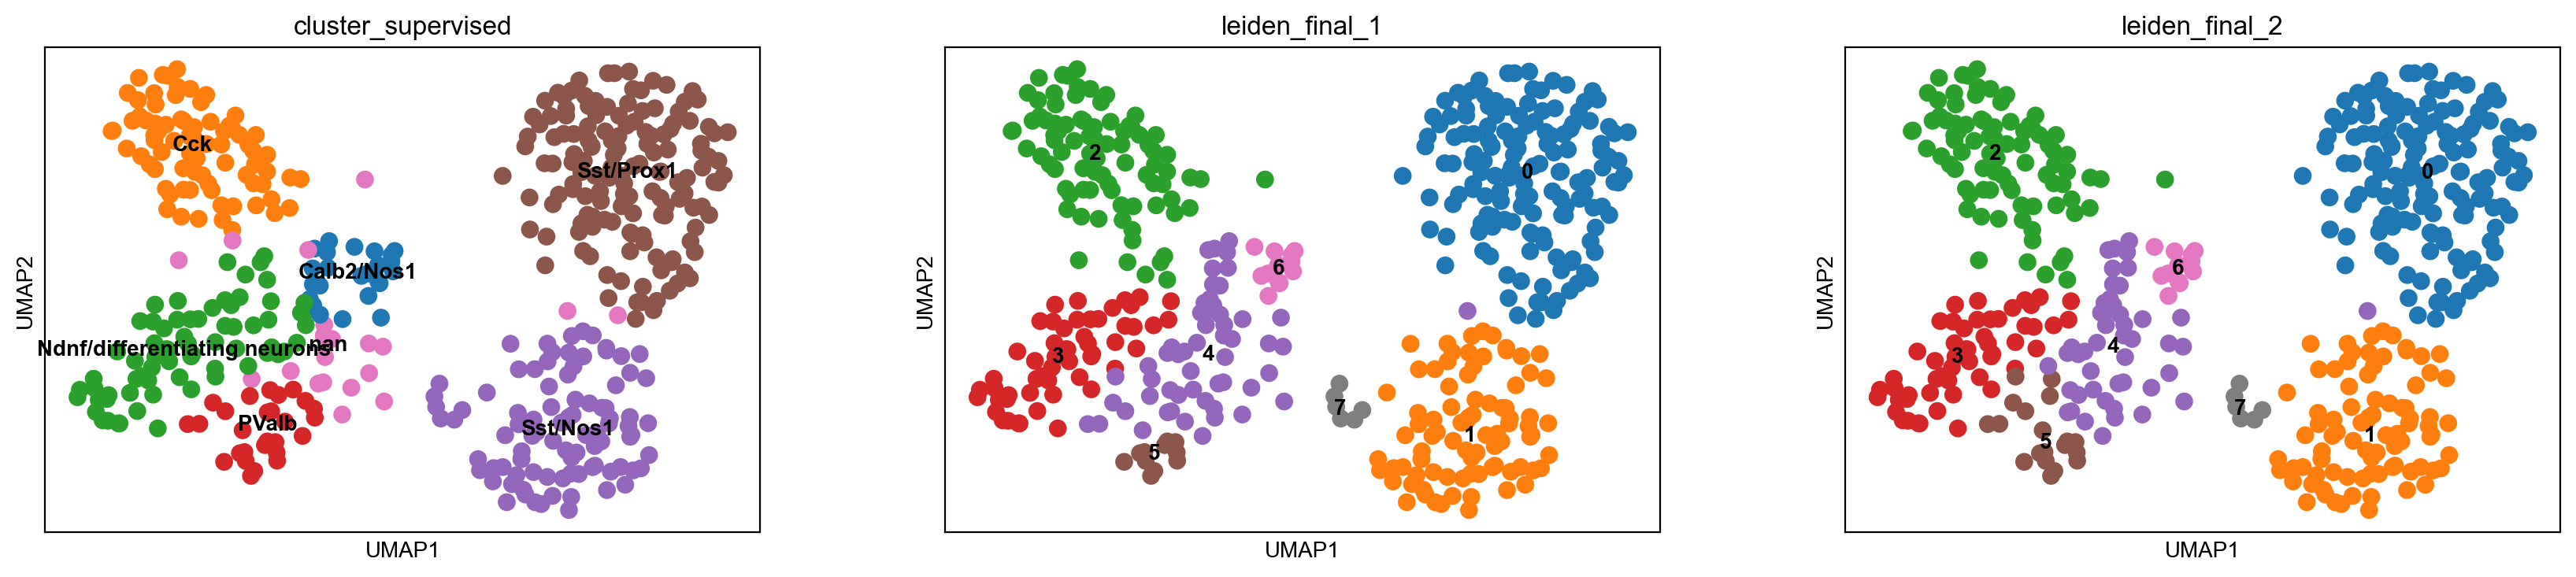

In [497]:
sc.pl.umap(slc32a1, color=["cluster_supervised", "leiden_final_1", "leiden_final_2"], legend_loc="on data")

In [503]:
slc32a1_nomacro = slc32a1[~slc32a1.obs.leiden_final_2.isin(["7"])].copy()

In [504]:
slc32a1_final = reorder_clusters_hierarchical(slc32a1_nomacro, "leiden_final_2")

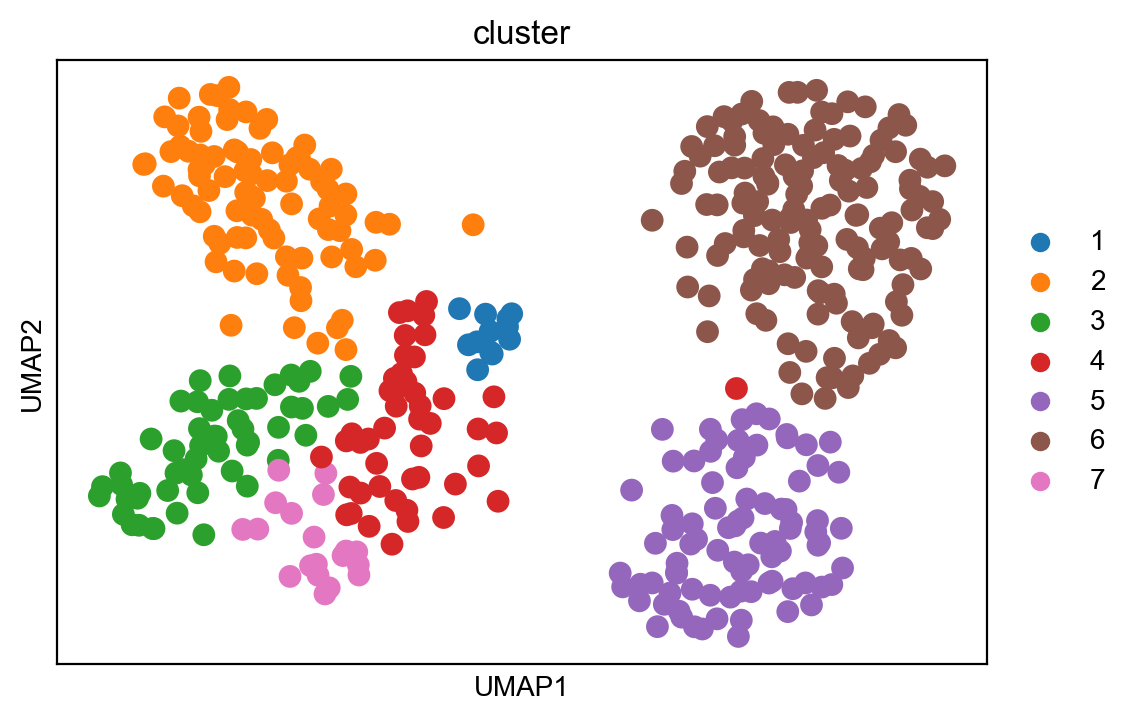

In [505]:
sc.pl.umap(slc32a1_final, color="cluster")

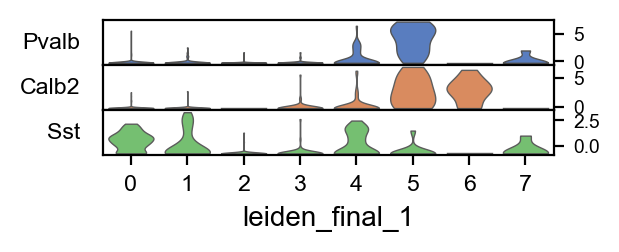

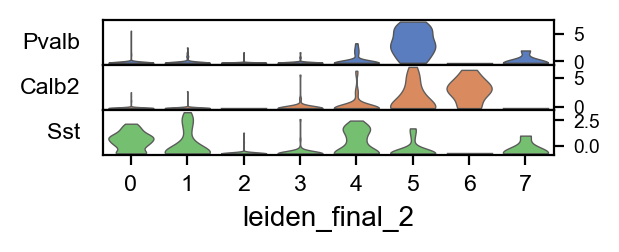

In [501]:
sc.pl.stacked_violin(slc32a1, ["Pvalb", "Calb2", "Sst"], groupby="leiden_final_1", swap_axes=True)
sc.pl.stacked_violin(slc32a1, ["Pvalb", "Calb2", "Sst"], groupby="leiden_final_2", swap_axes=True)

In [494]:
slc32a1_markers = "Lamp5 Slc6a5 Cck Dmbx1 Nos1 Ndnf Pvalb Calb2 Sst Prox1 Fst".split()

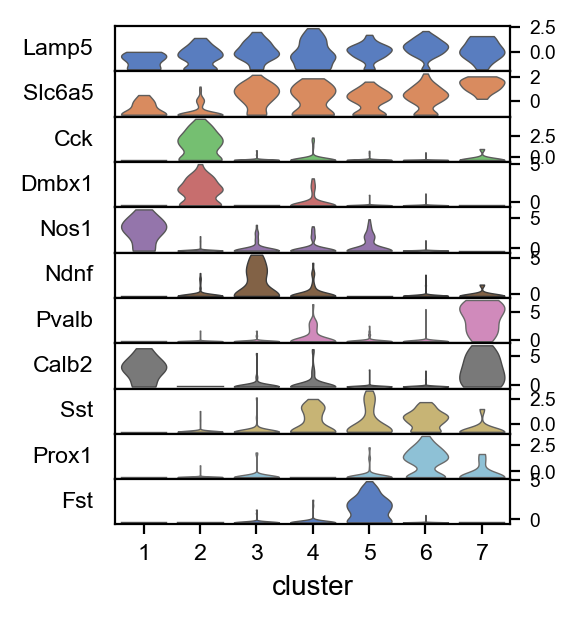

In [495]:
sc.pl.stacked_violin(slc32a1_final, slc32a1_markers, groupby="cluster", swap_axes=True)

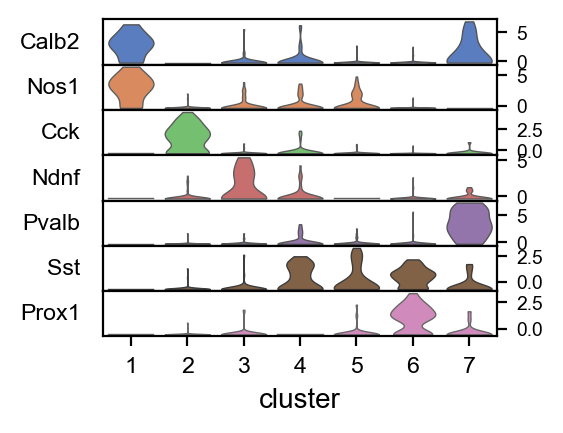

In [473]:
sc.pl.stacked_violin(slc32a1_final, ["Calb2", "Nos1", "Cck", "Ndnf", "Pvalb", "Sst", "Prox1"],
                     groupby="cluster", use_raw=False, swap_axes=True)

In [506]:
detect_umap_doublets(slc32a1_final, "cluster", t=6)

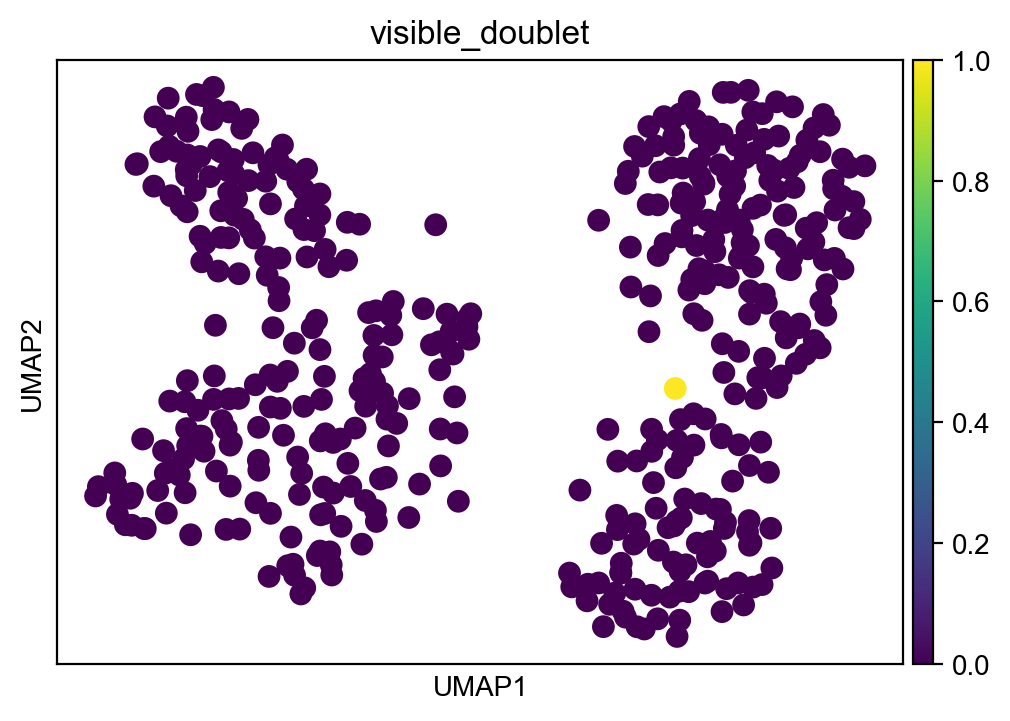

In [507]:
sc.pl.umap(slc32a1_final, color="visible_doublet")

In [508]:
#save_adata(slc17a6_final, "slc17a6-final")
save_adata(slc32a1_final, "slc32a1-final")

# Redo full UMAP to look less squished

In [47]:
full = sc.read(OUTPUT_DIR / "h5ad" / "neuronal_agg-clustered-2020-05-31T11-00-35.h5ad")

In [50]:
sc.tl.umap(full, min_dist=0.7)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


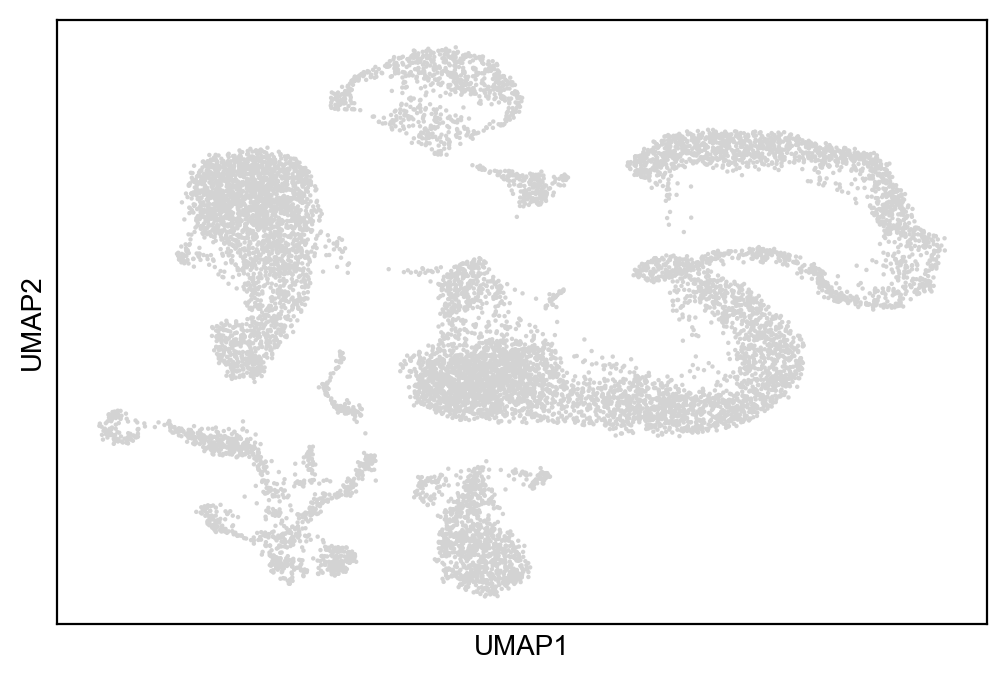

In [51]:
sc.pl.umap(full)

In [52]:
save_adata(full, "spread")